In [13]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ARIMA model and autocorrelation plots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

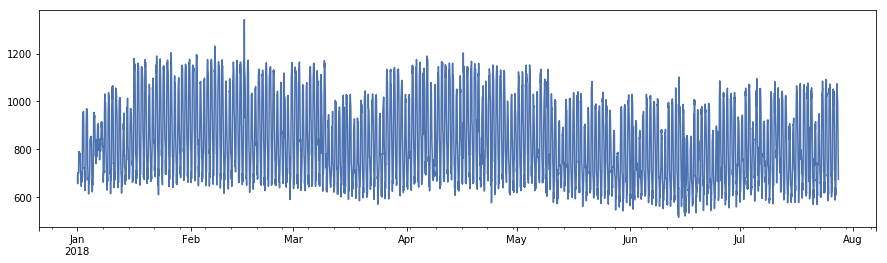

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

# sum the remaining buildings
y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

y.plot(figsize=(15,4))

### Hour of week AND week of year transformer

This transformer calculates the hour of week average (array of 168 values). This captures the weekend and weekday variations at the hourly level. Then, to catch effects like winter and spring break, the week of the year average is transformed out.

As of now, this transformer is performing the best.

In [3]:
# create a dummy dataframe to handle complicated time operations
df = pd.DataFrame(y,columns=['demand'],index=y.index)
df['hourofweek'] = y.values

k=1
for i in range(len(df)):
    df['hourofweek'][i] = k
    k = k+1
    if k == 168: k=0
avg_hourofweek = y.groupby(df['hourofweek']).mean()
df['avg_hourofweek'] = df['hourofweek'].map(avg_hourofweek)

hourofweek_mean = df['avg_hourofweek'].values

# week of year calculation is easily built in to pandas
weekofyear_mean = y.index.weekofyear.map(y.groupby(y.index.weekofyear).mean()).values

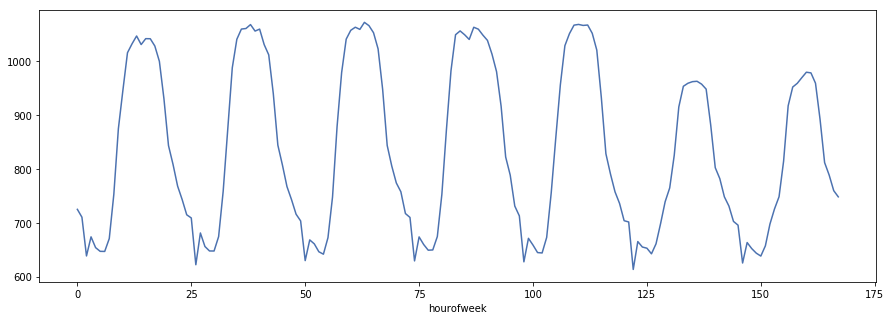

In [4]:
avg_hourofweek.plot(figsize=(15,5))

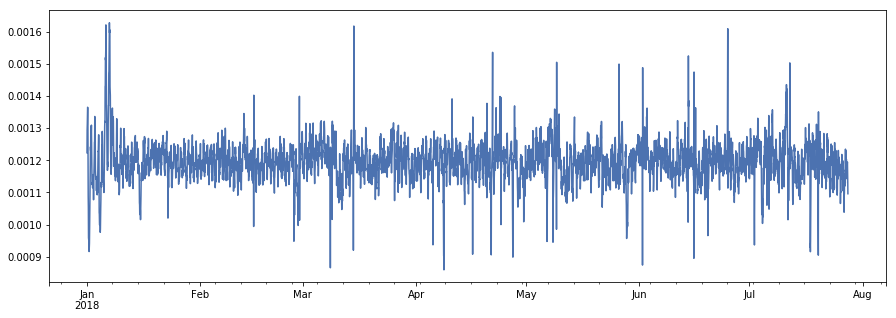

In [5]:
# combine both week of year and hourofweek effects to identity
y_trans = (y/weekofyear_mean)
y_trans = (y_trans/hourofweek_mean)

# export results to csv, to untransform, multiply by hourofweek_mean, then weekofyear_mean
transformers = pd.DataFrame({'demand':y,'weekofyear_trans':weekofyear_mean,'hourofweek_trans':hourofweek_mean})
transformers.to_csv('../data/elec_transformations.csv')

y_trans.plot(figsize=(15,5))

### Applied to ARIMA model

Here I apply the transformed series to ARIMA with 24 hour differencing.

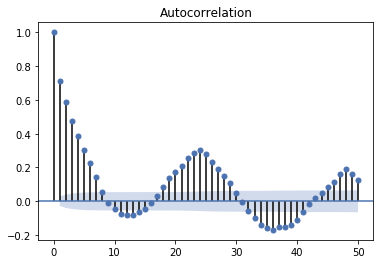

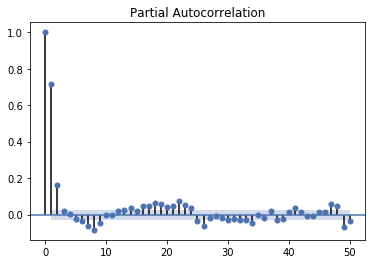

In [6]:
# rename y_trans to y, because the code below is recycled
y = y_trans.copy(deep=True)

plot_acf(y, lags=50)
plt.show()
plot_pacf(y, lags=50)
plt.show()

In [7]:
# helper functions for ARIMA forecasting

def difference(dataset, interval=1):
    """Returns the difference over a specific interval"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    """Inverts a series that has been differenced"""
    return yhat + history[-interval]


In [18]:
# construct empty dataframe to populate with results
mapes = pd.DataFrame(columns=['hours_trained','mape'])
y_predicted = y.copy(deep=True)

# define split times and end times to cut X and y into training and testing sets
split_times = pd.date_range(start='2018-02-10 08:00:00',freq='D',periods=100)
end_times = split_times.shift(39,freq='H')

# loop to run models and add hours_trained & mape data to the mapes dataframe
for i in range(len(split_times)):
    
    # define training and testing sets based on split_times and end_times
    y_train = y.loc[y.index <= split_times[i]].copy().values
    y_test = y.loc[(y.index > split_times[i]) & (y.index <= end_times[i])].copy()
      
    # calculate the 24-hour difference on the training data
    differenced = difference(y_train, 24)

    # fit the model to the differenced data
    model = ARIMA(differenced, order=(7,0,1))
    model_fit = model.fit(disp=0,maxiter=200)

    # multi-step out-of-sample forecast
    forecast = model_fit.forecast(steps=39)[0]

    # invert the differenced forecast and store results
    history = [i for i in y_train]
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, 24)
        history.append(inverted)
    
    y_pred = history[len(history)-39:]
    y_predicted.loc[(y.index > split_times[i]) & (y.index <= end_times[i])] = y_pred
    
    # store the results of the model and append the mapes dataframe
    hours_trained = len(y_train)
    mape = np.mean(np.abs((y_test[15:] - y_pred[15:]) / y_test[15:]))*100
    mapes = mapes.append({'hours_trained':hours_trained,'mape':mape},ignore_index=True)

print('The average MAPE over a {} day test period was {}'.format(len(mapes),np.round(np.mean(mapes['mape']),3)))

The average MAPE over a 100 day test period was 7.045


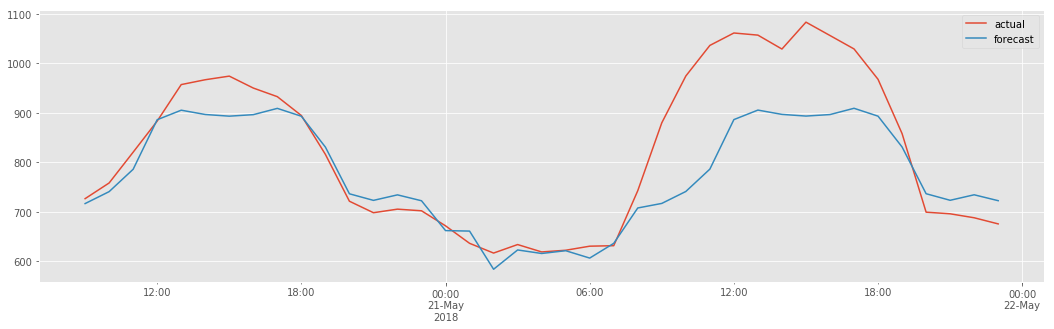

In [19]:
latest_forecast = pd.DataFrame(y_test,columns=['actual'])
latest_forecast['forecast'] = y_pred

latest_forecast.plot(figsize=(18,5))

In [20]:
# un-transform the result
y_predicted = y_predicted*hourofweek_mean*weekofyear_mean
y = y*hourofweek_mean*weekofyear_mean

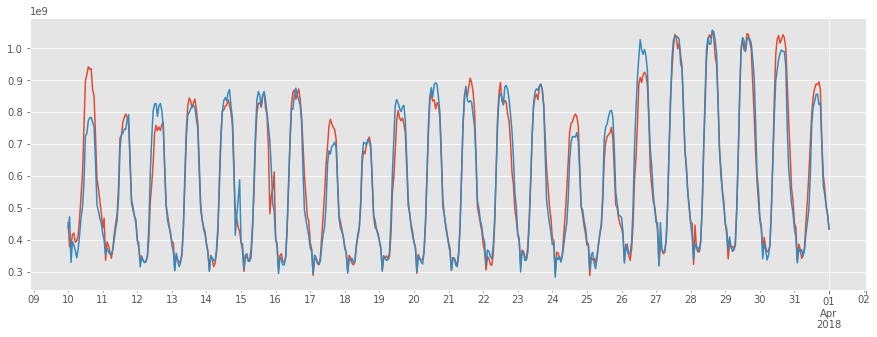

In [23]:
y_predicted.loc['2018-03-10 00:00:00':'2018-04-01 00:00:00'].plot(figsize=(15,5))
y.loc['2018-03-10 00:00:00':'2018-04-01 00:00:00'].plot()